In [1]:
import os
os.chdir('/cluster/home/bdayan/girgs/benji_src/notebooks/')

'/cluster/home/bdayan/girgs/benji_src/notebooks'

/cluster/scratch/bdayan/GIRG_data/socfb-Caltech36.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Reed98.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Haverford76.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Simmons81.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Swarthmore42.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Amherst41.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Bowdoin47.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Hamilton46.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Trinity100.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-USFCA72.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Williams40.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Oberlin44.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Wellesley22.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Smith60.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Vassar85.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Middlebury45.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Pepperdine8

In [2]:
import sys
sys.path.append('../')
sys.path.append('../../nemo-eva/src/')

import os
os.getcwd()



'/cluster/home/bdayan/girgs/benji_src/notebooks'

In [18]:
from benji_girgs import utils, generation, points, fitting
import os
import glob
import pandas as pd
import networkit

import networkit as nk


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np
import matplotlib.pyplot as plt

import do_feature_extract
import networkx as nx


<module 'benji_girgs.generation' from '../benji_girgs/generation.py'>

<module 'benji_girgs.fitting' from '../benji_girgs/fitting.py'>

In [19]:
%matplotlib notebook

const_in: 12.35748152211654


../benji_girgs/generation.py:424: RuntimeWarning: divide by zero encountered in true_divide
  puv = np.stack([np.ones(original_edge_dists.shape), const_in * ((wu * wv / W) / original_edge_dists ** d) ** alpha]).min(axis=0)
../benji_girgs/generation.py:425: RuntimeWarning: divide by zero encountered in true_divide
  puv_cube = np.stack([np.ones(cube_edge_dists.shape), const_in * ((wu * wv / W) / cube_edge_dists ** d) ** alpha]).min(axis=0)


Network Properties:
nodes, edges			5000, 235023
directed?			False
weighted?			False
isolated nodes			0
self-loops			0
density				0.018806
clustering coefficient		0.553681
min/max/avg degree		14, 4850, 94.009200
degree assortativity		-0.176677
number of connected components	1
size of largest component	5000 (100.00 %)


In [9]:
import importlib
importlib.reload(generation)
importlib.reload(fitting)

CPU times: user 42.8 ms, sys: 11 ms, total: 53.8 ms
Wall time: 52.2 ms


array([[0.        , 0.37284425, 0.58050998, ..., 0.75874127, 0.18234182,
        0.60228748],
       [0.37284425, 0.        , 0.29831461, ..., 0.65973309, 0.55518607,
        0.32009212],
       [0.58050998, 0.29831461, 0.        , ..., 0.6990982 , 0.59455117,
        0.23199064],
       ...,
       [0.75874127, 0.65973309, 0.6990982 , ..., 0.        , 0.64808346,
        0.46710756],
       [0.18234182, 0.55518607, 0.59455117, ..., 0.64808346, 0.        ,
        0.49162968],
       [0.60228748, 0.32009212, 0.23199064, ..., 0.46710756, 0.49162968,
        0.        ]])

In [14]:
b = 2.0
n = 1500
d = 1
tau = 2.1
alpha=1.2
desiredAvgDegree=100.0

g, edges, weights, pts, const = generation.generate_GIRG_nk(n, d, tau, alpha, desiredAvgDegree=desiredAvgDegree, points_type=points.PointsCube)
nk.overview(g)

gnx = nk.nxadapter.nk2nx(g)
A = nx.adjacency_matrix(gnx).todense()

const_in = generation.const_conversion(const, alpha, d, true_volume=True)
p_uv = generation.get_probs(weights / np.sqrt(weights.sum()), pts, alpha, const_in)

In [15]:
def girg_loglikelihood(A, p_uv):
    """
        A: adjacency matrix nxn
        p_uv: probability matrix

    Returns:

    """
    A_bar = -A + 1
    # no self loops
    np.fill_diagonal(A, 0)
    np.fill_diagonal(A_bar, 0)

    # this is all very painful, maybe we can just clip p_uv not to be 0 or 1
    eps = 1e-7
    p_uv = np.clip(p_uv, eps, 1 - eps)

    # self.p_uv has some 0s and 1s, so np.log gives some -inf. We
    # do nan_to_num which makes -inf -> large negative number, s.t.
    # A_ij * ?_ij is 0 and not nan when previously ?_ij was -inf.

    # of course if A_ij is not 0, i.e. we have an edge, yet still
    # self.p_uv is 0, we -ve large, and log_likelihood will be
    # -inf probably. :(
    log_likelihood = np.sum(
        A * np.nan_to_num((np.log(p_uv))) +
        A_bar * np.nan_to_num((np.log(1 - p_uv)))
    )

    return log_likelihood

54.1 ms ± 1.28 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [16]:
gnx = nk.nxadapter.nk2nx(g)
A = nx.adjacency_matrix(gnx).todense()

const_in = generation.const_conversion(const, alpha, d, true_volume=True)
p_uv = generation.get_probs(weights / np.sqrt(weights.sum()), pts, alpha, const_in)

54 ms ± 1.82 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [224]:
fitting.girg_loglikelihood(A, p_uv)

PointsTorus2(-215374.1472412)

In [225]:
pts_init = points.PointsTorus2(np.random.uniform(size=(n, d)))
fitting.girg_loglikelihood(A, generation.get_probs(weights / np.sqrt(weights.sum()), pts_init, alpha, const_in))

PointsTorus2(-912635.16100014)

In [121]:
pts_temp = pts.copy()
pts_temp[0] = [0.5, 0.5]
# for i in range(len(pts_temp)):
#     for j in range(d):
#         pts_temp[i][j] = max(min(0, pts_temp[i][j] + np.random.normal(0, 0.1)), 1)

p_uv_temp = generation.get_probs(weights / np.sqrt(weights.sum()), pts_temp, alpha, const_in)

# much lower :)
fitting.girg_loglikelihood(A, p_uv_temp)

PointsTorus2(-219362.80161586)

In [161]:
x = pts_temp[0].copy()
pts_temp[0] = [0.5, 0.9]

In [162]:
pts_temp
x

PointsTorus2([[0.5       , 0.9       ],
              [0.21699159, 0.83268538],
              [0.13882835, 0.78394861],
              ...,
              [0.57569804, 0.53633296],
              [0.36602612, 0.23769918],
              [0.91996682, 0.32568104]])

PointsTorus2([0.5, 0.5])

In [103]:
pts_temp

PointsTorus2([[1., 1.],
              [1., 1.],
              [1., 1.],
              ...,
              [1., 1.],
              [1., 1.],
              [1., 1.]])

In [151]:
u_index = 0
p_u_to_v = generation.get_probs_u(weights / np.sqrt(weights.sum()), pts, alpha, const_in, u_index)
eps = 1e-7
p_u_to_v = np.clip(p_u_to_v, eps, 1-eps)
# np.log(p_u_to_v[1:]).sum()

p_u_to_v2 = generation.get_probs_u(weights / np.sqrt(weights.sum()), pts_temp, alpha, const_in, u_index)
p_u_to_v2 = np.clip(p_u_to_v2, eps, 1-eps)
# np.log(p_u_to_v2[1:]).sum()


../benji_girgs/generation.py:78: RuntimeWarning: divide by zero encountered in true_divide
  p_uv = np.power(p_uv, alpha)


In [167]:
mask = np.ones(n, dtype=bool)
mask[u_index] = False
log_Q_u = A[u_index, mask] * np.log(p_u_to_v[mask]) + (1 - A[u_index, mask]) * np.log(1 - p_u_to_v[mask])
log_Q_u2 = A[u_index, mask] * np.log(p_u_to_v2[mask]) + (1 - A[u_index, mask]) * np.log(1 - p_u_to_v2[mask])

Q_ratio = np.exp(log_Q_u2.sum() - log_Q_u.sum())
acceptance_prob = np.minimum(1, Q_ratio)

In [168]:
log_Q_u.sum()
# is much more negative :)
log_Q_u2.sum()

PointsTorus2(-78.66932437)

PointsTorus2(-206.77136187)

In [169]:
acceptance_prob

PointsTorus2(2.32269397e-56)

In [153]:
np.argwhere(p_u_to_v == 1)

array([], shape=(0, 1), dtype=int64)

In [ ]:
mask = np.ones(n, dtype=bool)
mask[u_index] = False
log_Q_u = A[u_index, mask] * np.log(p_u_to_v[mask]) + (1 - A[u_index, mask]) * np.log(1 - p_u_to_v[mask])
log_Q_u2 = A[u_index, mask] * np.log(p_u_to_v2[mask]) + (1 - A[u_index, mask]) * np.log(1 - p_u_to_v2[mask])

In [146]:
np.argwhere(p_u_to_v == 0)

array([], shape=(0, 1), dtype=int64)

In [154]:
(log_Q_u > log_Q_u2).sum()

PointsTorus2(787)

# MCMC run attempt

In [256]:
pts_init = points.PointsTorus2(np.random.uniform(size=(n, d)))

pts_init2 = pts_init.copy()
pts_final, lls, num_acceptances = fitting.mcmc_girg(A, weights, alpha, d, const, pts_init, n_steps=20)

  0%|          | 0/20 [00:00<?, ?it/s]../benji_girgs/generation.py:78: RuntimeWarning: divide by zero encountered in true_divide
  p_uv = np.divide(wuwv, dists**d)
100%|██████████| 20/20 [00:03<00:00,  5.04it/s]


In [45]:
import importlib
importlib.reload(generation)
importlib.reload(fitting)
importlib.reload(points)

<module 'benji_girgs.generation' from '../benji_girgs/generation.py'>

<module 'benji_girgs.fitting' from '../benji_girgs/fitting.py'>

../benji_girgs/points.py:190: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert (n, d == other.shape)


<module 'benji_girgs.points' from '../benji_girgs/points.py'>

In [18]:
%matplotlib notebook

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
fig.show()
fig.canvas.draw()

<IPython.core.display.Javascript object>

In [4]:
# %matplotlib notebook
# pts_init = points.PointsTorus2(np.random.uniform(size=(n, d)))

pts_init = pts.copy()
pts_final, lls, num_acceptances = fitting.mcmc_girg(A, weights, alpha, d, const, pts_init, n_steps=500, plot_every=10)

NameError: name 'plt' is not defined

# Diffusion Map

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
fig.show()
fig.canvas.draw()

<IPython.core.display.Javascript object>

In [23]:
w, Phi, Psi, diff_map = utils.get_diffmap(g, Iweighting=0.5, eye_or_ones='eye')

pts_diffmap = np.array([diff_map(i, 5) for i in range(n)])
pts_diffmap = points.normalise_points_to_cube(pts_diffmap)
pts_diffmap = points.PointsTorus2(pts_diffmap[:, 0:1])

In [27]:
pts_init.shape
pts_diffmap.shape

100%|██████████| 5000/5000 [01:21<00:00, 61.57it/s] 


In [22]:
pts_diffmap_final, lls, num_acceptances = fitting.mcmc_girg(A, weights, alpha, d, const, pts_diffmap, n_steps=500, plot_every=10)

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
fig.show()
fig.canvas.draw()

<IPython.core.display.Javascript object>

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
fig.show()
fig.canvas.draw()

<IPython.core.display.Javascript object>

In [30]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
fig.show()
fig.canvas.draw()

<IPython.core.display.Javascript object>

In [31]:
import importlib
importlib.reload(fitting)

<module 'benji_girgs.fitting' from '../benji_girgs/fitting.py'>

In [32]:
pts_diffmap_final, lls, num_acceptances = fitting.mcmc_girg(A, weights, alpha, d, const, pts_diffmap_final, n_steps=10000, plot_every=40, ll_every=20)

 41%|████      | 4081/10000 [00:28<00:49, 118.48it/s]../benji_girgs/fitting.py:636: RuntimeWarning: overflow encountered in exp
  Q_ratio = np.exp(log_Q_u2_sum - log_Q_u_sum)
100%|██████████| 10000/10000 [01:09<00:00, 143.02it/s]


In [ ]:
p_uv

In [15]:
p_uv_temp = generation.get_probs(weights / np.sqrt(weights.sum()), pts, alpha, const_in)
fitting.girg_loglikelihood(A, p_uv_temp)

-202564.65497587007

In [16]:
p_uv_temp = generation.get_probs(weights / np.sqrt(weights.sum()), pts_diffmap, alpha, const_in)
fitting.girg_loglikelihood(A, p_uv_temp)

pts_init = points.PointsTorus2(np.random.uniform(size=(n, d)))
p_uv_temp = generation.get_probs(weights / np.sqrt(weights.sum()), pts_init, alpha, const_in)
fitting.girg_loglikelihood(A, pts_init)

PointsTorus2(-545737.59661584)

PointsTorus2(-2256629.02466131)

<Figure size 640x480 with 0 Axes>

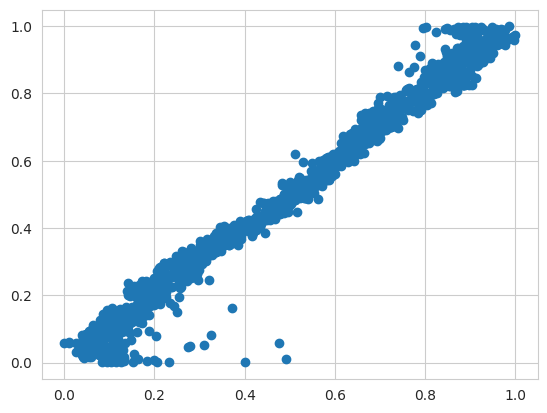

In [13]:
plt.figure()
plt.scatter(pts_diffmap[:, 0], pts[:, 0])

In [241]:
weights = weights / np.sqrt(weights.sum())
n = pts.shape[0]
num_acceptances = 0
const_in = generation.const_conversion(const, alpha, d, true_volume=True)
lls = []

u_index = np.random.randint(n)
x_u2 = np.random.uniform(size=1)
a_prob = fitting.acceptance_prob(A, weights, alpha, const_in, pts, u_index, x_u2)



In [243]:
a_prob.shape

(1500,)

In [245]:
np.arange(2000)[np.random.randint(n)]

35

In [253]:
weights

array([1.01645683, 7.01031457, 1.26122323, ..., 3.23281141, 1.08036674,
       1.69265171])

In [227]:
import tqdm

def mcmc_girg(A, weights, alpha, d, const, pts, n_steps=1000):
    n = pts.shape[0]
    num_acceptances = 0
    const_in = generation.const_conversion(const, alpha, d, true_volume=True)
    lls = []
    for _ in tqdm.tqdm(range(n_steps)):
        u_index = np.random.randint(n)
        x_u2 = np.random.uniform(size=1)
        accepted = fitting.acceptance_prob(A, weights, alpha, const_in, pts, u_index, x_u2)
        if accepted:
            lls.append(girg_loglikelihood(A, generation.get_probs(weights / np.sqrt(weights.sum()), pts, alpha, const_in)))
            num_acceptances += 1
            # print(f'{u_index}')

    return pts, lls, num_acceptances

In [228]:
pts_init = points.PointsTorus2(np.random.uniform(size=(n, d)))
pts_init2 = pts_init.copy()

pts_final, lls, num_acceptances = mcmc_girg(A, weights, alpha, d, const, pts_init, n_steps=20)

100%|██████████| 20/20 [00:03<00:00,  5.80it/s]


In [229]:
lls

[PointsTorus2(-903617.56095811),
 PointsTorus2(-903328.081093),
 PointsTorus2(-902999.23514528),
 PointsTorus2(-902844.9464741),
 PointsTorus2(-902729.40745499),
 PointsTorus2(-902586.44617774),
 PointsTorus2(-902415.52671104),
 PointsTorus2(-902358.00082185)]

In [213]:
pts_final[46]

PointsTorus2([0.91005611])

In [220]:
const_in = generation.const_conversion(const, alpha, d, true_volume=True)
fitting.girg_loglikelihood(A, generation.get_probs(weights, pts_init, alpha, const_in))
fitting.girg_loglikelihood(A, generation.get_probs(weights, pts, alpha, const_in))

PointsTorus2(-33832656.4560028)

PointsTorus2(-33832656.4560028)

In [221]:
pts
pts_init

PointsTorus2([[0.53379394],
              [0.28952514],
              [0.18260039],
              ...,
              [0.6101247 ],
              [0.37984138],
              [0.18430433]])

PointsTorus2([[0.3564775 ],
              [0.82364137],
              [0.85052508],
              ...,
              [0.48323176],
              [0.87092524],
              [0.68243028]])

In [219]:
pts_init

PointsTorus2([[0.3564775 ],
              [0.82364137],
              [0.85052508],
              ...,
              [0.48323176],
              [0.87092524],
              [0.68243028]])

In [191]:
n = pts_init.shape[0]
num_acceptances = 0
const_in = generation.const_conversion(const, alpha, d, true_volume=True)
lls = []

u_index = np.random.randint(n)
x_u2 = np.random.uniform(size=1)

# n = pts.shape[0]
eps = 1e-7
p_u_to_v = generation.get_probs_u(weights / np.sqrt(weights.sum()), pts, alpha, const_in, u_index)
x_u = pts[u_index].copy()
pts[u_index] = x_u2
p_u_to_v2 = generation.get_probs_u(weights / np.sqrt(weights.sum()), pts, alpha, const_in, u_index)
p_u_to_v2 = np.clip(p_u_to_v2, eps, 1 - eps)

mask = np.ones(n, dtype=bool)
mask[u_index] = False
log_Q_u = A[u_index, mask] * np.log(p_u_to_v[mask]) + (1 - A[u_index, mask]) * np.log(1 - p_u_to_v[mask])
log_Q_u2 = A[u_index, mask] * np.log(p_u_to_v2[mask]) + (1 - A[u_index, mask]) * np.log(1 - p_u_to_v2[mask])

Q_ratio = np.exp(log_Q_u2.sum() - log_Q_u.sum())
acceptance_prob = np.minimum(1, Q_ratio)

p = np.random.uniform()
accepted = acceptance_prob > p
if not accepted:
    pts[u_index] = x_u

../benji_girgs/generation.py:78: RuntimeWarning: divide by zero encountered in true_divide
  p_uv = np.divide(wuwv, dists**d)
/scratch/tmp.17453491.bdayan/ipykernel_57362/519760232.py:19: RuntimeWarning: divide by zero encountered in log
  log_Q_u = A[u_index, mask] * np.log(p_u_to_v[mask]) + (1 - A[u_index, mask]) * np.log(1 - p_u_to_v[mask])
/scratch/tmp.17453491.bdayan/ipykernel_57362/519760232.py:19: RuntimeWarning: invalid value encountered in multiply
  log_Q_u = A[u_index, mask] * np.log(p_u_to_v[mask]) + (1 - A[u_index, mask]) * np.log(1 - p_u_to_v[mask])


In [193]:
log_Q_u.sum()
log_Q_u2.sum()

PointsTorus2(nan)

PointsTorus2(-269.64158705)

In [194]:
np.argwhere(np.isnan(log_Q_u))

array([[  48],
       [  68],
       [ 193],
       [ 263],
       [ 328],
       [ 417],
       [ 461],
       [ 524],
       [ 583],
       [ 586],
       [ 617],
       [ 733],
       [ 801],
       [ 850],
       [1119],
       [1238],
       [1266],
       [1303],
       [1472]])

In [195]:
log_Q_u[47:53]

PointsTorus2([-0.00310993,         nan, -0.00098024, -0.00634206,
              -0.00520093, -0.00265187])

In [196]:
p_u_to_v[47:53]

PointsTorus2([3.10510320e-03, 1.00000000e+00, 9.79761955e-04,
              6.32198984e-03, 5.18743058e-03, 2.64836109e-03])

In [230]:
%timeit np.ones(10000)

5.5 µs ± 200 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [233]:
%time np.ones(10000)

CPU times: user 57 µs, sys: 2 µs, total: 59 µs
Wall time: 63.4 µs


array([1., 1., 1., ..., 1., 1., 1.])